In [1]:
from IPython.display import Image

<h1>Yolo v3 Object Detection</h1>

<p>Yolo v3를 활용한 객체 탐지(object detection)를 수행했다</p>
<ul></ul>

<h2>Object Detection</h2>

<p>객체 탐지</p>
<ul>
    <li>이미지나 비디오 프레임에서 여러 객체들을 찾아낸다</li>
    <li>각각의 객체가 어디에 있는지 바운딩 박스로 표시한다</li>
</ul>

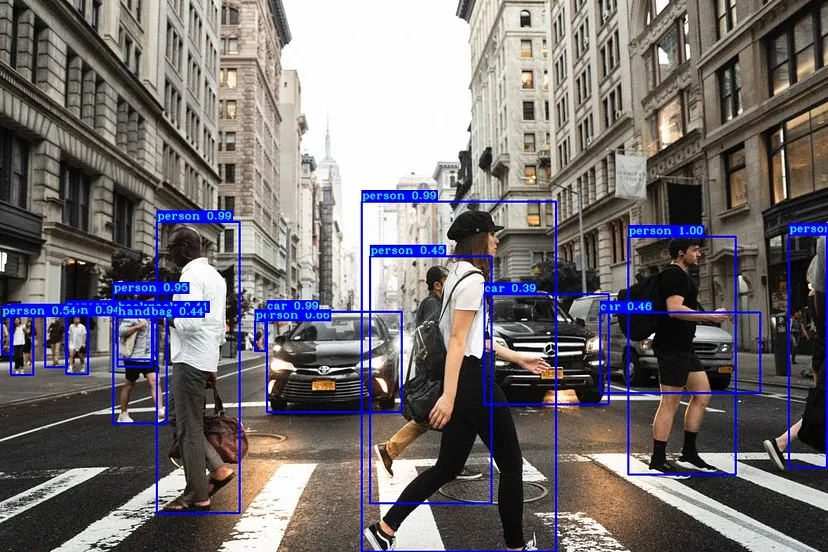

In [2]:
Image(filename='imagefile/objectdetection.jpg')

<h2>Yolo 개요</h2>

<p>입력 이미지를 그리드 셀로 나눠서 그 부분 내에서 객체를 예측한다</p>
<p>각 칸은 여러개의 바운딩 박스를 예측한다</p>

<p>각 바운딩 박스는 객체의 위치(x,y), 높이와 너비, 그리고 객체가 있을 확률(confidence)을 포함한다</p>

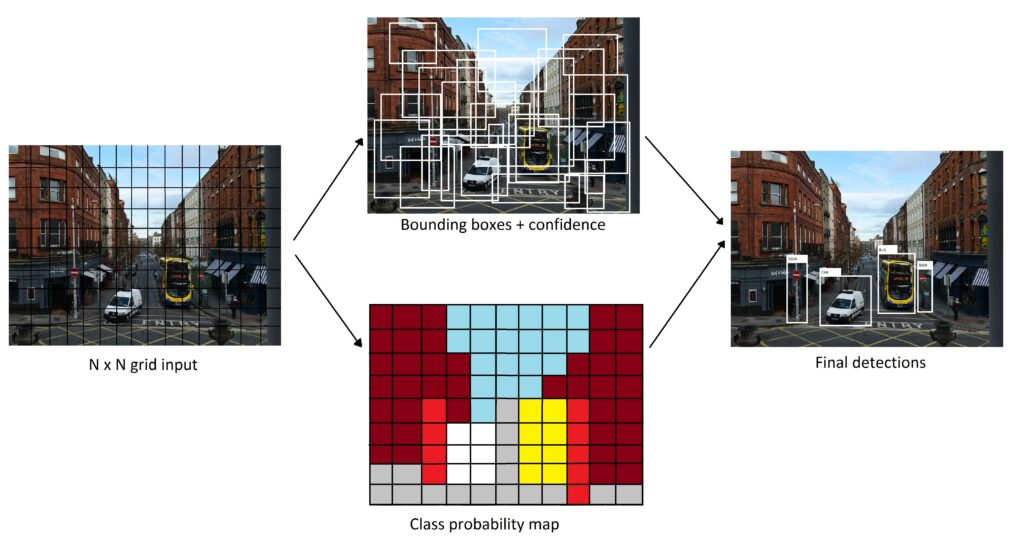

In [4]:
Image(filename='imagefile/yolo_diagram.jpg')

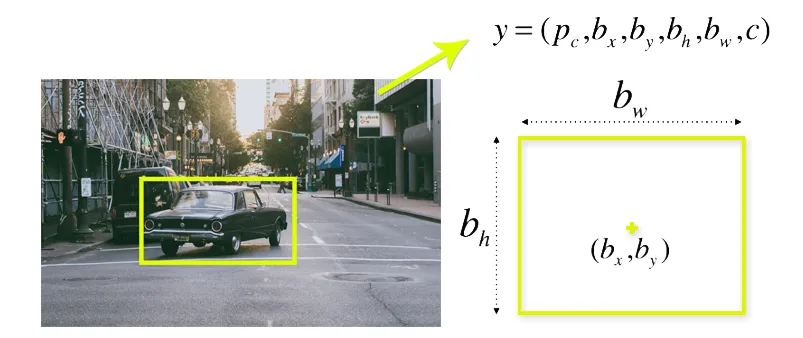

In [3]:
Image(filename='imagefile/boundingbox.jpg')

<p>먼저 필요한 패키지들을 로드해주었다</p>

In [5]:
!mkdir checkpoints
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from absl import logging
from itertools import repeat

from tensorflow.keras import Model
from tensorflow.keras.layers import Add, Concatenate, Lambda
from tensorflow.keras.layers import Conv2D, Input, LeakyReLU
from tensorflow.keras.layers import MaxPool2D, UpSampling2D, ZeroPadding2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.losses import sparse_categorical_crossentropy

<p>Yolo 모델 관련 변수 설정</p>

<p>YOLO 모델은 입력 이미지를 정사각형으로 변환하여 처리한다 416x416 크기로 이미지를 resize</p>
<p>예제에서는 COCO 데이터을 기반으로 학습된 weights파일을 사용했기 때문에 클래스 갯수는 80개로 지정</p>

In [6]:
yolo_iou_threshold   = 0.6 # iou threshold #객체 검출 시 경계 상자 간의 중첩을 비교 #non-max suppression에 사용
yolo_score_threshold = 0.6 # score threshold

weightsyolov3 = 'yolov3.weights' # path to weights file
weights= 'checkpoints/yolov3.weights.h5' # path to checkpoints file
size= 416             #resize images to\
checkpoints = 'checkpoints/yolov3.weights.h5'
num_classes = 80      # number of classes in the model

<p>Yolo 모델 레이어</p>
<ul>
    <li>yolo_darknet : YOLOv3의 백본 네트워크로, 특징 추출을 담당한다</li>
    <li>yolo_conv : YOLO의 다양한 합성곱 레이어이다</li>
    <li>yolo_output : YOLO의 출력 레이어로, 서로 다른 스케일에서 객체 검출을 수행한다</li>
</ul>

In [7]:
YOLO_V3_LAYERS = [
  'yolo_darknet',
  'yolo_conv_0',
  'yolo_output_0',
  'yolo_conv_1',
  'yolo_output_1',
  'yolo_conv_2',
  'yolo_output_2',
]

<p>Function to load weights from original Yolo trained model in Darknet</p>

In [8]:
def load_darknet_weights(model, weights_file):
  wf = open(weights_file, 'rb')
  major, minor, revision, seen, _ = np.fromfile(wf, dtype=np.int32, count=5)
  layers = YOLO_V3_LAYERS

  for layer_name in layers:
    sub_model = model.get_layer(layer_name)
    for i, layer in enumerate(sub_model.layers):
      if not layer.name.startswith('conv2d'):
        continue
      batch_norm = None
      if i + 1 < len(sub_model.layers) and \
            sub_model.layers[i + 1].name.startswith('batch_norm'):
        batch_norm = sub_model.layers[i + 1]

      logging.info("{}/{} {}".format(
        sub_model.name, layer.name, 'bn' if batch_norm else 'bias'))

      filters = layer.filters
      size = layer.kernel_size[0]
      in_dim = layer.input.shape[-1]

      if batch_norm is None:
        conv_bias = np.fromfile(wf, dtype=np.float32, count=filters)
      else:
        bn_weights = np.fromfile(
          wf, dtype=np.float32, count=4 * filters)

        bn_weights = bn_weights.reshape((4, filters))[[1, 0, 2, 3]]

      conv_shape = (filters, in_dim, size, size)
      conv_weights = np.fromfile(
        wf, dtype=np.float32, count=np.product(conv_shape))

      conv_weights = conv_weights.reshape(
        conv_shape).transpose([2, 3, 1, 0])

      if batch_norm is None:
        layer.set_weights([conv_weights, conv_bias])
      else:
        layer.set_weights([conv_weights])
        batch_norm.set_weights(bn_weights)

  assert len(wf.read()) == 0, 'failed to read all data'
  wf.close()

<p>Define function for calculating intersection over union</p>

In [9]:
def interval_overlap(interval_1, interval_2):
  x1, x2 = interval_1
  x3, x4 = interval_2
  if x3 < x1:
    return 0 if x4 < x1 else (min(x2,x4) - x1)
  else:
    return 0 if x2 < x3 else (min(x2,x4) - x3)

def intersectionOverUnion(box1, box2):
  intersect_w = interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
  intersect_h = interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
  intersect_area = intersect_w * intersect_h
  
  w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
  w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
  
  union_area = w1*h1 + w2*h2 - intersect_area
  return float(intersect_area) / union_area

<p>Function for drawing bounding box, class name and probability</p>

In [10]:
def draw_outputs(img, outputs, class_names):
  boxes, score, classes, nums = outputs
  boxes, score, classes, nums = boxes[0], score[0], classes[0], nums[0]
  wh = np.flip(img.shape[0:2])
  for i in range(nums):
    x1y1 = tuple((np.array(boxes[i][0:2]) * wh).astype(np.int32))
    x2y2 = tuple((np.array(boxes[i][2:4]) * wh).astype(np.int32))
    img = cv2.rectangle(img, x1y1, x2y2, (255, 0, 0), 2)
    img = cv2.putText(img, '{} {:.4f}'.format(
      class_names[int(classes[i])], score[i]),
      x1y1, cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 255), 2)
  return img

<p>Batch Normalization</p>

In [11]:
class BatchNormalization(tf.keras.layers.BatchNormalization):
  def call(self, x, training=False):
    if training is None: training = tf.constant(False)
    training = tf.logical_and(training, self.trainable)
    return super().call(x, training)

<p>Defining 3 anchor boxes for each grid</p>

<p>anchor box들의 크기들을 사전 정의</p>
<p>예측된 박스의 중심 좌표, 너비, 높이를 anchor box 크기와 결합하여 최종 예측 박스를 생성한다.</p>
<p>anchor mask들은 세가지 예측 레이어에서 각각 사용된다.</p>

In [12]:
yolo_anchors = np.array([(10, 13), (16, 30), (33, 23), (30, 61), (62, 45),
                        (59, 119), (116, 90), (156, 198), (373, 326)], np.float32) / 416
yolo_anchor_masks = np.array([[6, 7, 8], [3, 4, 5], [0, 1, 2]])

<h2>Darknet 53 – YOLOv3</h2>

<p>YOLOv3는 Darknet-53이라는 53개의 컨볼루션 레이어를 가진 네트워크를 사용한다</p>

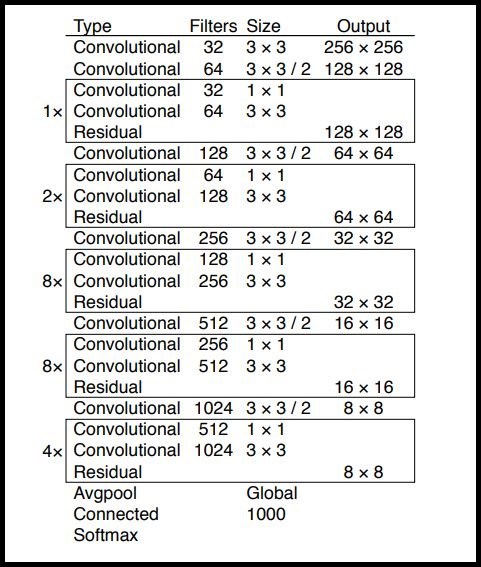

In [13]:
Image(filename='imagefile/yolo-arch.jpg')

<ul>
    <li>DarknetCov : Darknet 네트워크의 컨볼루션 레이어를 생성하는 함수이다. 필요한 경우 배치 정규화와 LeakyReLU 활성화 함수를 적용한다.</li>
    <li>DarknetResidual : Darknet 네트워크의 잔여블록(Residual Block_그래디언트 소실 문제 해결)을 생성하는 함수이다. 이 함수는 먼저 입력을 절반으로 줄이고, 그 다음 두 개의 컨볼루션 레이어를 거친 후 이전 입력과 결합한다.</li>
    <li>DarknetBlock : Darknet 네트워크의 블록을 생성하는 함수이다. 이 함수는 컨볼루션 레이어와 잔여 블록을 반복하여 네트워크의 깊이를 증가시킨다.</li>
    <li>Darknet : Darknet 네트워크 전체를 생성하는 함수이다. 이 함수는 입력 레이어와 여러 개의 Darknet 블록을 통해 네트워크를 구성한다.</li></ol>
</ul>

In [14]:
def DarknetConv(x, filters, size, strides=1, batch_norm=True):
  if strides == 1:
    padding = 'same'
  else:
    x = ZeroPadding2D(((1, 0), (1, 0)))(x)  # top left half-padding
    padding = 'valid'
  x = Conv2D(filters=filters, kernel_size=size,
          strides=strides, padding=padding,
          use_bias=not batch_norm, kernel_regularizer=l2(0.0005))(x)
  if batch_norm:
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
  return x

def DarknetResidual(x, filters):
  previous  = x
  x = DarknetConv(x, filters // 2, 1)
  x = DarknetConv(x, filters, 3)
  x = Add()([previous , x])
  return x


def DarknetBlock(x, filters, blocks):
  x = DarknetConv(x, filters, 3, strides=2)
  for _ in repeat(None, blocks):
    x = DarknetResidual(x, filters)       
  return x


def Darknet(name=None):
  x = inputs = Input([None, None, 3])
  x = DarknetConv(x, 32, 3) #첫 번째 컨볼루션 레이어: 32개의 필터, 커널 크기 3x3
  x = DarknetBlock(x, 64, 1) #첫 번째 블록: 64개의 필터, 1개의 Residual Block
  x = DarknetBlock(x, 128, 2) #두 번째 블록: 128개의 필터, 2개의 Residual Blocks
  x = x_36 = DarknetBlock(x, 256, 8) #세 번째 블록: 256개의 필터, 8개의 Residual Blocks
  x = x_61 = DarknetBlock(x, 512, 8) #네 번째 블록: 512개의 필터, 8개의 Residual Blocks
  x = DarknetBlock(x, 1024, 4) #다섯 번째 블록: 1024개의 필터, 4개의 Residual Blocks
  return tf.keras.Model(inputs, (x_36, x_61, x), name=name)

<p>YoloConv : YOLO 모델의 컨볼루션 블록을 정의하는 함수이다. 이 블록은 입력을 받아서 여러 컨볼루션 레이어를 거쳐 특징 맵을 생성한다.</p>

In [15]:
def YoloConv(filters, name=None):
  def yolo_conv(x_in):
    if isinstance(x_in, tuple):
      inputs = Input(x_in[0].shape[1:]), Input(x_in[1].shape[1:])
      x, x_skip = inputs

      x = DarknetConv(x, filters, 1)
      x = UpSampling2D(2)(x)
      x = Concatenate()([x, x_skip])
    else:
      x = inputs = Input(x_in.shape[1:])

    x = DarknetConv(x, filters, 1)
    x = DarknetConv(x, filters * 2, 3)
    x = DarknetConv(x, filters, 1)
    x = DarknetConv(x, filters * 2, 3)
    x = DarknetConv(x, filters, 1)
    return Model(inputs, x, name=name)(x_in)
  return yolo_conv

<p>YoloOutput : YOLO 모델의 출력 레이어를 생성하는 함수이다. 이 함수는 객체 검출 결과를 생성한다.</p>

In [16]:
def YoloOutput(filters, anchors, classes, name=None):
  def yolo_output(x_in):
    x = inputs = Input(x_in.shape[1:])
    x = DarknetConv(x, filters * 2, 3)
    x = DarknetConv(x, anchors * (classes + 5), 1, batch_norm=False)
    x = Lambda(lambda x: tf.reshape(x, (-1, tf.shape(x)[1], tf.shape(x)[2],
                                        anchors, classes + 5)))(x)
    return tf.keras.Model(inputs, x, name=name)(x_in)
  return yolo_output

<p>yolo_boxes : 예측 결과를 박스로 변환하는 함수이다. YOLO 모델의 예측 값을 실제 이미지 상의 bounding box로 변환하는 과정을 수행한다.</p>

In [17]:
def yolo_boxes(pred, anchors, classes):
  grid_size = tf.shape(pred)[1]
  box_xy, box_wh, score, class_probs = tf.split(pred, (2, 2, 1, classes), axis=-1)

  box_xy = tf.sigmoid(box_xy)
  score = tf.sigmoid(score)
  class_probs = tf.sigmoid(class_probs)
  pred_box = tf.concat((box_xy, box_wh), axis=-1)

  grid = tf.meshgrid(tf.range(grid_size), tf.range(grid_size))
  grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)

  box_xy = (box_xy + tf.cast(grid, tf.float32)) /  tf.cast(grid_size, tf.float32)
  box_wh = tf.exp(box_wh) * anchors

  box_x1y1 = box_xy - box_wh / 2
  box_x2y2 = box_xy + box_wh / 2
  bbox = tf.concat([box_x1y1, box_x2y2], axis=-1)

  return bbox, score, class_probs, pred_box

<p>Non-maximum suppression</p>

<p>nonMaximumSuppression : YOLO 네트워크의 출력에서 비최대 억제를 수행하는 함수이다. 이 함수는 겹치는 경계 상자를 제거하고 최종 객체를 결정한다.</p>

In [18]:
def nonMaximumSuppression(outputs, anchors, masks, classes):
  boxes, conf, out_type = [], [], []

  for output in outputs:
    boxes.append(tf.reshape(output[0], (tf.shape(output[0])[0], -1, tf.shape(output[0])[-1])))
    conf.append(tf.reshape(output[1], (tf.shape(output[1])[0], -1, tf.shape(output[1])[-1])))
    out_type.append(tf.reshape(output[2], (tf.shape(output[2])[0], -1, tf.shape(output[2])[-1])))

  bbox = tf.concat(boxes, axis=1)
  confidence = tf.concat(conf, axis=1)
  class_probs = tf.concat(out_type, axis=1)

  scores = confidence * class_probs
  
  boxes, scores, classes, valid_detections = tf.image.combined_non_max_suppression(
    boxes=tf.reshape(bbox, (tf.shape(bbox)[0], -1, 1, 4)),
    scores=tf.reshape(
        scores, (tf.shape(scores)[0], -1, tf.shape(scores)[-1])),
    max_output_size_per_class=100,
    max_total_size=100,
    iou_threshold=yolo_iou_threshold,
    score_threshold=yolo_score_threshold
  )
  
  return boxes, scores, classes, valid_detections

<p>YoloV3 : YOLOv3 모델 전체를 생성하는 함수이다. 이 함수는 입력 이미지를 받아 Darknet 네트워크와 YOLO 레이어를 통해 객체를 감지한다.</p>

<p>Darknet 네트워크 적용</p>
<ul>
    <li>'Darknet' 함수를 사용하여 입력 이미지에 Darknet 네트워크를 적용한다</li>
    <li>Darknet 네트워크는 입력 이미지를 다양한 레이어로 변환하여 특징을 추출하는 역할을 한다</li>
    <li>Darknet 네트워크의 출력은 x_36, x_61 및 x로 저장된다</li>
</ul>
<p>YOLO 레이어 적용</p>
<ul>
    <li>YOLO 네트워크는 Darknet 네트워크의 출력을 입력으로 받습니다</li>
    <li>YoloConv 함수를 사용하여 각각의 출력 레이어에 YOLO 컨볼루션 레이어를 적용한다</li>
    <li>이 컨볼루션 레이어는 객체 검출을 수행하는 데 사용된다</li>
    <li>YoloOutput 함수를 사용하여 YOLO 출력 레이어를 정의한다. 이 레이어는 경계 상자와 클래스 확률을 예측한다</li>
</ul>
<p>학습 여부에 따른 처리</p>
<ul>
    <li>training 매개변수를 기준으로, 학습 중인지를 확인하여 다른 처리를 수행한다</li>
    <li>학습 중이 아닌 경우, 비최대 억제(non-maximum suppression)를 수행하여 겹치는 경계 상자를 제거하고 최종 객체를 결정</li>
</ul>

In [20]:
def YoloV3(size=None, channels=3, anchors=yolo_anchors,
          masks=yolo_anchor_masks, classes=80, training=False):
  x = inputs = Input([size, size, channels])

  x_36, x_61, x = Darknet(name='yolo_darknet')(x)

  x = YoloConv(512, name='yolo_conv_0')(x)
  output_0 = YoloOutput(512, len(masks[0]), classes, name='yolo_output_0')(x)

  x = YoloConv(256, name='yolo_conv_1')((x, x_61))
  output_1 = YoloOutput(256, len(masks[1]), classes, name='yolo_output_1')(x)

  x = YoloConv(128, name='yolo_conv_2')((x, x_36))
  output_2 = YoloOutput(128, len(masks[2]), classes, name='yolo_output_2')(x)

  if training:
    return Model(inputs, (output_0, output_1, output_2), name='yolov3')

  boxes_0 = Lambda(lambda x: yolo_boxes(x, anchors[masks[0]], classes),
                  name='yolo_boxes_0')(output_0)
  boxes_1 = Lambda(lambda x: yolo_boxes(x, anchors[masks[1]], classes),
                  name='yolo_boxes_1')(output_1)
  boxes_2 = Lambda(lambda x: yolo_boxes(x, anchors[masks[2]], classes),
                  name='yolo_boxes_2')(output_2)

  outputs = Lambda(lambda x: nonMaximumSuppression(x, anchors, masks, classes),
                  name='nonMaximumSuppression')((boxes_0[:3], boxes_1[:3], boxes_2[:3]))

  return Model(inputs, outputs, name='yolov3')

<p>YoloLoss : YOLOv3 네트워크의 손실 함수를 정의하는 함수이다. 이 함수는 모델의 출력과 실제 값 사이의 손실을 계산한다.</p>

In [21]:
def YoloLoss(anchors, classes=80, ignore_thresh=0.5):
    def yolo_loss(y_true, y_pred):
        # 1. transform all pred outputs
        # y_pred: (batch_size, grid, grid, anchors, (x, y, w, h, obj, ...cls))
        pred_box, pred_obj, pred_class, pred_xywh = yolo_boxes(
            y_pred, anchors, classes)
        pred_xy = pred_xywh[..., 0:2]
        pred_wh = pred_xywh[..., 2:4]

        # 2. transform all true outputs
        # y_true: (batch_size, grid, grid, anchors, (x1, y1, x2, y2, obj, cls))
        true_box, true_obj, true_class_idx = tf.split(
            y_true, (4, 1, 1), axis=-1)
        true_xy = (true_box[..., 0:2] + true_box[..., 2:4]) / 2
        true_wh = true_box[..., 2:4] - true_box[..., 0:2]

        # give higher weights to small boxes
        box_loss_scale = 2 - true_wh[..., 0] * true_wh[..., 1]

        # 3. inverting the pred box equations
        grid_size = tf.shape(y_true)[1]
        grid = tf.meshgrid(tf.range(grid_size), tf.range(grid_size))
        grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)
        true_xy = true_xy * tf.cast(grid_size, tf.float32) - \
            tf.cast(grid, tf.float32)
        true_wh = tf.math.log(true_wh / anchors)
        true_wh = tf.where(tf.math.is_inf(true_wh),
                           tf.zeros_like(true_wh), true_wh)

        # 4. calculate all masks
        obj_mask = tf.squeeze(true_obj, -1)
        # ignore false positive when iou is over threshold
        true_box_flat = tf.boolean_mask(true_box, tf.cast(obj_mask, tf.bool))
        best_iou = tf.reduce_max(broadcast_iou(
            pred_box, true_box_flat), axis=-1)
        ignore_mask = tf.cast(best_iou < ignore_thresh, tf.float32)

        # 5. calculate all losses
        xy_loss = obj_mask * box_loss_scale * \
            tf.reduce_sum(tf.square(true_xy - pred_xy), axis=-1)
        wh_loss = obj_mask * box_loss_scale * \
            tf.reduce_sum(tf.square(true_wh - pred_wh), axis=-1)
        obj_loss = binary_crossentropy(true_obj, pred_obj)
        obj_loss = obj_mask * obj_loss + \
            (1 - obj_mask) * ignore_mask * obj_loss
        # TODO: use binary_crossentropy instead
        class_loss = obj_mask * sparse_categorical_crossentropy(
            true_class_idx, pred_class)

        # 6. sum over (batch, gridx, gridy, anchors) => (batch, 1)
        xy_loss = tf.reduce_sum(xy_loss, axis=(1, 2, 3))
        wh_loss = tf.reduce_sum(wh_loss, axis=(1, 2, 3))
        obj_loss = tf.reduce_sum(obj_loss, axis=(1, 2, 3))
        class_loss = tf.reduce_sum(class_loss, axis=(1, 2, 3))

        return xy_loss + wh_loss + obj_loss + class_loss
    return yolo_loss

In [22]:
@tf.function
def transform_targets_for_output(y_true, grid_size, anchor_idxs, classes):

  N = tf.shape(y_true)[0]

  y_true_out = tf.zeros(
      (N, grid_size, grid_size, tf.shape(anchor_idxs)[0], 6))

  anchor_idxs = tf.cast(anchor_idxs, tf.int32)

  indexes = tf.TensorArray(tf.int32, 1, dynamic_size=True)
  updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)
  idx = 0
  for i in tf.range(N):
    for j in tf.range(tf.shape(y_true)[1]):
      if tf.equal(y_true[i][j][2], 0):
        continue
      anchor_eq = tf.equal(
        anchor_idxs, tf.cast(y_true[i][j][5], tf.int32))

      if tf.reduce_any(anchor_eq):
        box = y_true[i][j][0:4]
        box_xy = (y_true[i][j][0:2] + y_true[i][j][2:4]) / 2

        anchor_idx = tf.cast(tf.where(anchor_eq), tf.int32)
        grid_xy = tf.cast(box_xy // (1/grid_size), tf.int32)

        indexes = indexes.write(
            idx, [i, grid_xy[1], grid_xy[0], anchor_idx[0][0]])
        updates = updates.write(
          idx, [box[0], box[1], box[2], box[3], 1, y_true[i][j][4]])
        idx += 1

  return tf.tensor_scatter_nd_update(
    y_true_out, indexes.stack(), updates.stack())


def transform_targets(y_train, anchors, anchor_masks, classes):
  outputs = []
  grid_size = 13

  anchors = tf.cast(anchors, tf.float32)
  anchor_area = anchors[..., 0] * anchors[..., 1]
  box_wh = y_train[..., 2:4] - y_train[..., 0:2]
  box_wh = tf.tile(tf.expand_dims(box_wh, -2),
                    (1, 1, tf.shape(anchors)[0], 1))
  box_area = box_wh[..., 0] * box_wh[..., 1]
  intersection = tf.minimum(box_wh[..., 0], anchors[..., 0]) * \
    tf.minimum(box_wh[..., 1], anchors[..., 1])
  iou = intersection / (box_area + anchor_area - intersection)
  anchor_idx = tf.cast(tf.argmax(iou, axis=-1), tf.float32)
  anchor_idx = tf.expand_dims(anchor_idx, axis=-1)

  y_train = tf.concat([y_train, anchor_idx], axis=-1)

  for anchor_idxs in anchor_masks:
    outputs.append(transform_targets_for_output(
      y_train, grid_size, anchor_idxs, classes))
    grid_size *= 2

  return tuple(outputs) # [x, y, w, h, obj, class]



def preprocess_image(x_train, size):
  return (tf.image.resize(x_train, (size, size))) / 255

In [23]:
yolo = YoloV3(classes=num_classes)

load_darknet_weights(yolo, weightsyolov3)

yolo.save_weights(checkpoints)

class_names =  ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
  "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
  "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
  "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
  "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
  "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl",
  "banana","apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut",
  "cake","chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop",
  "mouse","remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink",
  "refrigerator","book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]

C:\Users\rhkdw\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


C:\Users\rhkdw\AppData\Local\Temp\ipykernel_12552\1191356966.py:3: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  load_darknet_weights(yolo, weightsyolov3)


In [25]:
image = cv2.imread('dog.jpg')
name = 'test.jpg'     # path to test image
cv2.imwrite(name, image)

True

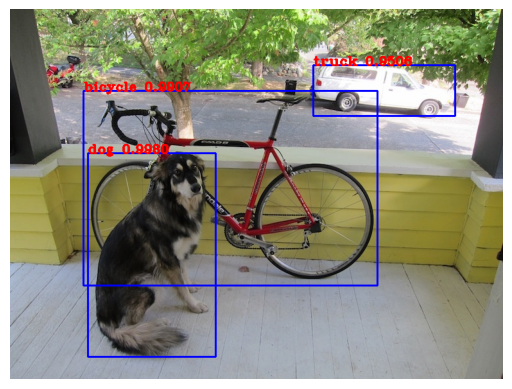

In [26]:
img = tf.image.decode_image(open(name, 'rb').read(), channels=3)
img = tf.expand_dims(img, 0)
img = preprocess_image(img, size)

boxes, scores, classes, nums = yolo(img) #eager mode

img = cv2.imread(name)
img = draw_outputs(img, (boxes, scores, classes, nums), class_names)
cv2.imwrite('output.jpg', img)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')  # 이미지 축 제거
plt.show()

<h2>Yolo 네트워크 구조 시각화</h2>

<p>1. Input Layer</p>
<p>2. Darknet : 세 가지 크기의 특징 맵을 생성한다</p>
<ul>
    <li>(None, None, None, 256): 작은 크기 특징 맵 (x_36)</li>
    <li>(None, None, None, 512): 중간 크기 특징 맵 (x_61)</li>
    <li>(None, None, None, 1024): 큰 크기 특징 맵 (x)</li>
</ul>
<p>3. YOLO Convolutional Layers : 다양한 크기의 특징 맵을 사용하여 추가적인 컨볼루션을 적용한다</p>
<ul>
    <li>yolo_conv_0: 큰 특징 맵에서 추가적인 컨볼루션을 적용하여 출력한다</li>
    <li>yolo_conv_1: 중간 크기 특징 맵과 큰 특징 맵을 결합한 후 추가적인 컨볼루션을 적용한다</li>
    <li>yolo_conv_2: 작은 크기 특징 맵과 중간 크기 특징 맵을 결합한 후 추가적인 컨볼루션을 적용한다</li>
</ul>
<p>4. YOLO Output Layers : 출력 형태(None, None, None, 3, 85)</p>
<ul>
    <li>3 : 각 앵커 박스 수</li>
    <li>85 : 4 (바운딩 박스 좌표) + 1 (객체 존재 여부) + 80 (클래스 확률)</li>
</ul>
<p>5. YOLO Boxes</p>
<ul>
    <li>Lambda Layers (yolo_boxes_0, yolo_boxes_1, yolo_boxes_2) : YOLO 출력값을 바운딩 박스 좌표, 객체 존재 여부, 클래스 확률로 분리</li>
</ul>
<p>6. Non-Maximum Suppression</p>
<ul>
    <li>Non-Maximum Suppression을 적용하여 겹치는 바운딩 박스를 제거하고 최종적으로 100개의 가장 확실한 바운딩 박스를 출력한다</li>
</ul>

In [24]:
yolo.summary()

Model: "yolov3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, None, None, 3)     │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ yolo_darknet (Functional)     │ [(None, None, None, 256), │      40,620,640 │ input_layer[0][0]          │
│                               │ (None, None, None, 512),  │                 │                            │
│                               │ (None, None, None, 1024)] │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ yolo_conv_0 (Functional)      │ (None, None, None, 512)   │      11,024,384 │ yolo_darknet[0][2]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ yolo_conv_1 (Functional)      │ (None, None, None, 256)   │       2,957,312 │ yolo_conv_0[0][0],         │
│                               │                           │                 │ yolo_darknet[0][1]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ yolo_conv_2 (Functional)      │ (None, None, None, 128)   │         741,376 │ yolo_conv_1[0][0],         │
│                               │                           │                 │ yolo_darknet[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ yolo_output_0 (Functional)    │ (None, None, None, 3, 85) │       4,984,063 │ yolo_conv_0[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ yolo_output_1 (Functional)    │ (None, None, None, 3, 85) │       1,312,511 │ yolo_conv_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ yolo_output_2 (Functional)    │ (None, None, None, 3, 85) │         361,471 │ yolo_conv_2[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ yolo_boxes_0 (Lambda)         │ [(None, None, None, 3,    │               0 │ yolo_output_0[0][0]        │
│                               │ 4), (None, None, None, 3, │                 │                            │
│                               │ 1), (None, None, None, 3, │                 │                            │
│                               │ 80), (None, None, None,   │                 │                            │
│                               │ 3, 4)]                    │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ yolo_boxes_1 (Lambda)         │ [(None, None, None, 3,    │               0 │ yolo_output_1[0][0]        │
│                               │ 4), (None, None, None, 3, │                 │                            │
│                               │ 1), (None, None, None, 3, │                 │                            │
│                               │ 80), (None, None, None,   │                 │                            │
│                               │ 3, 4)]                    │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ yolo_boxes_2 (Lambda)         │ [(None, None, None, 3,    │               0 │ yolo_output_2[0][0]        │
│                               │ 4), (None, None, None, 3, │               

 Total params: 62,001,757 (236.52 MB)

 Trainable params: 61,949,149 (236.32 MB)

 Non-trainable params: 52,608 (205.50 KB)

<h2>Model Training</h2>

<p>Roboflow.ai 사이트의 'Pistols Dataset'을 사용했다</p>
<a href="https://public.roboflow.com/object-detection/pistols">데이터셋 주소</a>
<p>"pistol"이라는 단일 클래스로 구성되어있고 3000개의 권총 이미지 파일과 각 이미지 내에서 권총이 있는 부분의 (x,y)좌표, width, height값 등을 포함한 txt파일이 존재한다.</p>

가상GPU 사용을 위해 colab에서 진행

<p>YOLO 모델을 불러오고 pre-trained된 Darknet-53의 가중치를 불러온다.</p>

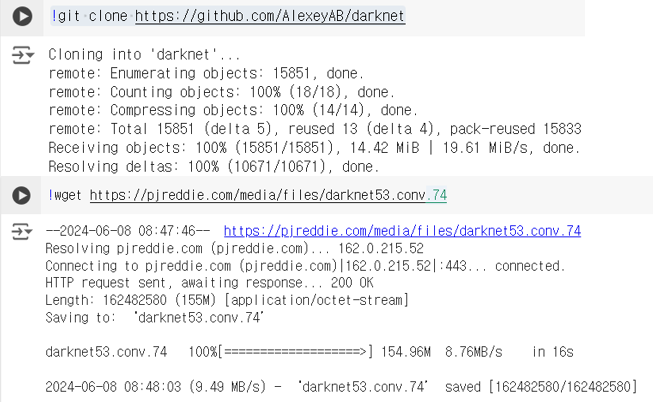

In [27]:
Image(filename='imagefile/loadweight.png')

<p>detector.data : 학습에 필요한 데이터 설정 파일들의 경로(학습 이미지 경로, 클래스 이름 파일의 경로, 모델 가중치를 저장할 경로)</p>
<p>custom.cfg : Yolov3 모델의 아키텍처와 학습 설정 정의(학습 속도, 배치 크기 등)</p>
<p>위에서 불러왔던 pre-trained 가중치 파일을 초기 가중치로 사용했다. -훈련을 더 빠르게하기 위해</p>

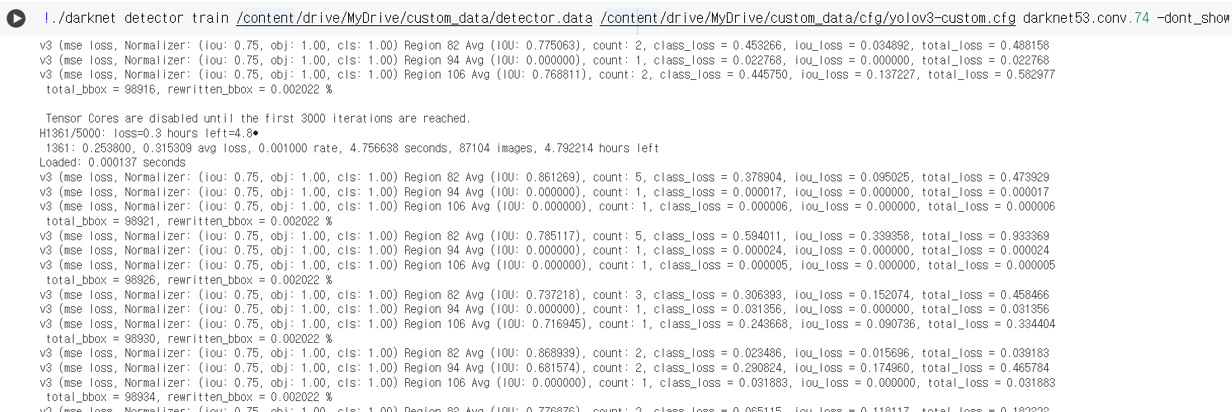

In [28]:
Image(filename='imagefile/train.png')

<h2>Test</h2>

<p>1000번 학습 시킨 weight파일을 사용(yolov3-custom_1000.weights)</p>
<p>1000번 학습 시켰을 때 대략 0.3~0.4의 loss값. (1시간~2시간 소요)</p>

In [29]:
weightsyolov3 = 'yolov3-custom_1000.weights' # path to weights file
weights= 'checkpoints/yolov3-custom_1000.weights.h5' # path to checkpoints file
size= 416             #resize images to\
checkpoints = 'checkpoints/yolov3-custom_1000.weights.h5'
num_classes = 1      # number of classes in the model

In [30]:
yolo = YoloV3(classes=num_classes)

load_darknet_weights(yolo, weightsyolov3)

yolo.save_weights(checkpoints)

class_names =  ["Pistol"]

C:\Users\rhkdw\AppData\Local\Temp\ipykernel_12552\1907566844.py:3: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  load_darknet_weights(yolo, weightsyolov3)


In [31]:
image = cv2.imread('pistol.jpg')
name = 'test_custom.jpg'     # path to test image
cv2.imwrite(name, image)

True

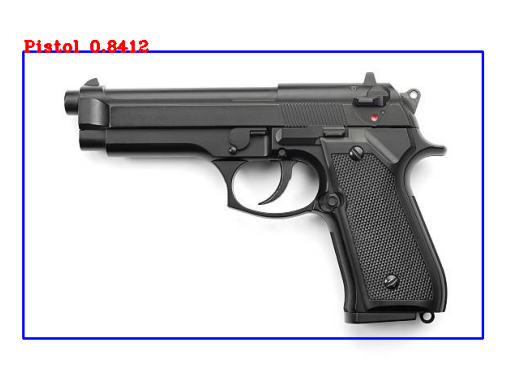

In [32]:
img = tf.image.decode_image(open(name, 'rb').read(), channels=3)
img = tf.expand_dims(img, 0)
img = preprocess_image(img, size)

boxes, scores, classes, nums = yolo(img) #eager mode

img = cv2.imread(name)
img = draw_outputs(img, (boxes, scores, classes, nums), class_names)
cv2.imwrite('output_custom.jpg', img)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')  # 이미지 축 제거
plt.show()

In [33]:
image = cv2.imread('pistol2.jpg')
name = 'test2_custom.jpg'     # path to test image
cv2.imwrite(name, image)

True

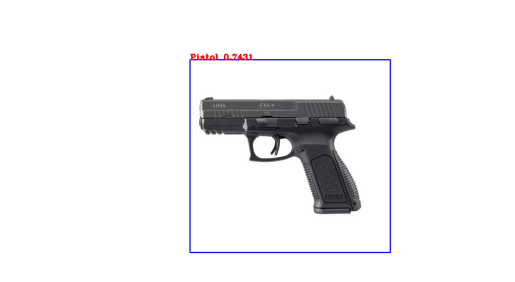

In [34]:
img = tf.image.decode_image(open(name, 'rb').read(), channels=3)
img = tf.expand_dims(img, 0)
img = preprocess_image(img, size)

boxes, scores, classes, nums = yolo(img) #eager mode

img = cv2.imread(name)
img = draw_outputs(img, (boxes, scores, classes, nums), class_names)
cv2.imwrite('output2_custom.jpg', img)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')  # 이미지 축 제거
plt.show()

<h2>References</h2>

<ol>
    <li><a href="https://colab.research.google.com/github/maticvl/dataHacker/blob/master/CNN/DataHacker_rs_%20YoloV3%20TF2.0.ipynb#scrollTo=wn4zLXKs9OCI">https://colab.research.google.com/github/maticvl/dataHacker/blob/master/CNN/DataHacker_rs_%20YoloV3%20TF2.0.ipynb#scrollTo=wn4zLXKs9OCI</a></li>
    <li><a href="https://www.youtube.com/watch?v=2_9M9XH8EDc">Yolo Train</a></li>
    <li><a href="https://datahacker.rs/how-to-peform-yolo-object-detection-using-keras/">https://datahacker.rs/how-to-peform-yolo-object-detection-using-keras/</a></li>
    <li><a href="https://medium.com/analytics-vidhya/yolov3-object-detection-in-tensorflow-2-x-8a1a104c46a8">https://medium.com/analytics-vidhya/yolov3-object-detection-in-tensorflow-2-x-8a1a104c46a8</a></li>
    <li><a href="https://pjreddie.com/darknet/yolo/#google_vignette">https://pjreddie.com/darknet/yolo/#google_vignette</a></li>
</ol>